# GEOTRACES 
found online from https://geotraces.webodv.awi.de/IDP2021_v2%3EGEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v2/service/DataExploration <br> 
more recent data (2018-2020) is kindly provided by Racquelle Mangahas and Jay Cullen.

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from cartopy import crs, feature
import numpy as np
import cmocean as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.dates as mdates

In [2]:
grid = xr.open_dataset('/data1/parker/LO_data/grids/cas6/grid.nc')
#line p data from 2012-2020
lp = pd.read_csv("/data1/bbeutel/LO_user/tracers/TM_LineP_2012-2020_RobynTaves.csv").drop([0], axis=0).reset_index().drop(['index'], axis=1)
# data from geotraces, line p data dropped so we done get duplicates
geo = xr.open_dataset("/data1/bbeutel/LO_user/tracers/data_from_GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v2.nc").drop_sel(N_STATIONS=[42,43,44,45,46,47,48,49,50,51])


In [3]:
lp.columns

Index(['Cruise ID', 'Season', 'Month', 'Station ID', 'Event ID',
       'Start Date (UTC)', 'Start Time (UTC)', 'Start Latitude',
       'Start Longitude', 'Sample ID', 'Sigmat', 'Density', 'Depth',
       'Mn_D_CONC_BOTTLE', '1SD::Mn_D_CONC_BOTTLE', 'Flag::Mn_D_CONC_BOTTLE',
       'Fe_D_CONC_BOTTLE', '1SD::Fe_D_CONC_BOTTLE', 'Flag::Fe_D_CONC_BOTTLE',
       'Co_D_CONC_BOTTLE', '1SD::Co_D_CONC_BOTTLE', 'Flag::Co_D_CONC_BOTTLE',
       'Ni_D_CONC_BOTTLE', '1SD::Ni_D_CONC_BOTTLE', 'Flag::Ni_D_CONC_BOTTLE',
       'Cu_D_CONC_BOTTLE', '1SD::Cu_D_CONC_BOTTLE', 'Flag::Cu_D_CONC_BOTTLE',
       'Zn_D_CONC_BOTTLE', '1SD::Zn_D_CONC_BOTTLE', 'Flag::Zn_D_CONC_BOTTLE',
       'Cd_D_CONC_BOTTLE', '1SD::Cd_D_CONC_BOTTLE', 'Flag::Cd_D_CONC_BOTTLE'],
      dtype='object')

In [68]:
lp['date']=pd.to_datetime(lp['Start Date (UTC)'])
lp['Start Latitude']=pd.to_numeric(lp['Start Latitude'])
lp['Start Longitude']=pd.to_numeric(lp['Start Longitude'])

/tmp/ipykernel_222373/1937242491.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  lp['date']=pd.to_datetime(lp['Start Date (UTC)'])


In [6]:
# geotraces stations with temperature and salinity data: 
st = []
for i in geo.N_STATIONS:
    if np.max(geo.CTDTMP_T_VALUE_SENSOR[i,:]).values > 0 :
        if np.max(geo.CTDSAL_D_CONC_SENSOR[i,:]).values > 0 :
            # print(i.values)
            st = np.append(st,int(i.values))
# everything except the line-p data which we already dropped!

In [10]:
# date range of geotraces data
print(np.min(geo.date_time).values,'-',np.max(geo.date_time).values)

2015-09-05T01:31:43.999948880 - 2018-10-14T04:01:58.999763584


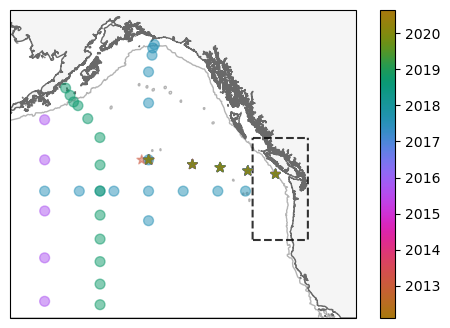

In [70]:
xlim, ylim = [-165, -115], [33, 62]
fig, ax = plt.subplots(figsize=(6, 4), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('high', edgecolor='dimgray', facecolor='whitesmoke', zorder=2))
# Draw 1000 m isobar
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical', edgecolor='dimgray', facecolor='white', alpha=0.5))

# Draw model box
ax.plot(grid['lon_rho'][ :,  0], grid['lat_rho'][ :,  0], 'k--', alpha=0.8, zorder=3, transform=crs.PlateCarree())
ax.plot(grid['lon_rho'][ :, -1], grid['lat_rho'][ :, -1], 'k--', alpha=0.8, zorder=3, transform=crs.PlateCarree())
ax.plot(grid['lon_rho'][ 0,  :], grid['lat_rho'][ 0,  :], 'k--', alpha=0.8, zorder=3, transform=crs.PlateCarree())
ax.plot(grid['lon_rho'][-1,  :], grid['lat_rho'][-1,  :], 'k--', alpha=0.8, zorder=3, transform=crs.PlateCarree())

# color based on year
lp_stations = lp.drop(lp.columns[9:-2],axis=1).groupby(['Station ID', 'date_']).first()
date2num = mdates.date2num(lp_stations['date'].values)  # Convert datetime objects to Matplotlib's internal format
date2num2 = mdates.date2num(geo.date_time)  # Convert datetime objects to Matplotlib's internal format
colormap = cm.cm.phase
normalize = Normalize(min(date2num), max(date2num))

sc = ax.scatter([geo.longitude[int(i)]-360 for i in st],
                [geo.latitude[int(i)] for i in st],
                c=[date2num2[int(i)] for i in st],
                s=50,
                cmap=colormap,
                norm=normalize,
                transform=crs.PlateCarree(),
                zorder=4,
                alpha=0.5)

sc = ax.scatter(lp_stations['Start Longitude'].values-360,
                lp_stations['Start Latitude'].values,
                c=date2num,
                s=50,
                cmap=colormap,
                norm=normalize,
                transform=crs.PlateCarree(),
                marker='*',
                zorder=4,
                alpha=0.5)

cbar = fig.colorbar(ScalarMappable(norm=normalize, cmap=colormap), ax=ax)
cbar.ax.yaxis.set_major_locator(mdates.AutoDateLocator())
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# plt.savefig("GEOTRACESmap.png")

In [71]:
lp_stations.index

MultiIndex([('P12', '2012-02-11'),
            ('P12', '2012-08-18'),
            ('P12', '2012-08-19'),
            ('P12', '2013-08-25'),
            ('P12', '2013-09-03'),
            ('P12', '2014-02-22'),
            ('P12', '2014-08-24'),
            ('P12', '2015-02-13'),
            ('P12', '2015-02-14'),
            ('P12', '2015-08-23'),
            ('P12', '2016-06-08'),
            ('P12', '2016-06-09'),
            ('P12', '2017-06-07'),
            ('P12', '2017-06-08'),
            ('P12', '2017-08-19'),
            ('P12', '2018-09-15'),
            ('P12', '2019-08-17'),
            ('P12', '2020-08-15'),
            ('P16', '2012-02-12'),
            ('P16', '2012-02-13'),
            ('P16', '2012-08-20'),
            ('P16', '2012-08-21'),
            ('P16', '2013-02-10'),
            ('P16', '2013-08-26'),
            ('P16', '2013-08-27'),
            ('P16', '2014-08-25'),
            ('P16', '2015-02-15'),
            ('P16', '2015-08-25'),
            ('P16', 

In [43]:
# ok lets see which stations have the other variables
ox = []
phos = []
sil = []
nitra = []
nitri = []
no23 = []
Al = [] 
Ba = [] 
Cd = [] 
Co = [] 
Cu = [] 
Fe = [] 
Ga = [] 
Mn = [] 
Ni = [] 
Pb = [] 

for i in geo.N_STATIONS:
    if np.max(geo.OXYGEN_D_CONC_BOTTLE[i,:]).values > 0 or np.max(geo.CTDOXY_D_CONC_SENSOR[i,:]).values > 0:
            ox = np.append(ox,int(i.values))
    if np.max(geo.PHOSPHATE_D_CONC_BOTTLE[i,:]).values > 0 or np.max(geo.PHOSPHATE_D_CONC_PUMP[i,:]).values > 0 :
            phos = np.append(phos,int(i.values))
    if np.max(geo.SILICATE_D_CONC_BOTTLE[i,:]).values > 0 or np.max(geo.SILICATE_D_CONC_PUMP[i,:]).values > 0 :
            sil = np.append(sil,int(i.values))
    if np.max(geo.NITRATE_D_CONC_BOTTLE[i,:]).values > 0 or np.max(geo.NITRATE_D_CONC_PUMP[i,:]).values > 0 :
            nitra = np.append(nitra,int(i.values))
    if np.max(geo.NITRITE_D_CONC_BOTTLE[i,:]).values > 0 or np.max(geo.NITRITE_D_CONC_PUMP[i,:]).values > 0 :
            nitri = np.append(nitri,int(i.values))
    if np.max(geo.Al_D_CONC_BOTTLE[i,:]).values > 0:
            Al = np.append(Al,int(i.values))
    if np.max(geo.Ba_D_CONC_BOTTLE[i,:]).values > 0:
            Ba = np.append(Ba,int(i.values))
    if np.max(geo.Cd_D_CONC_BOTTLE[i,:]).values > 0:
            Cd = np.append(Cd,int(i.values))
    if np.max(geo.Co_D_CONC_BOTTLE[i,:]).values > 0:
            Co = np.append(Co,int(i.values))
    if np.max(geo.Cu_D_CONC_BOTTLE[i,:]).values > 0:
            Cu = np.append(Cu,int(i.values))
    if np.max(geo.Fe_D_CONC_BOTTLE[i,:]).values > 0:
            Fe = np.append(Fe,int(i.values))
    if np.max(geo.Ga_D_CONC_BOTTLE[i,:]).values > 0:
            Ga = np.append(Ga,int(i.values))
    if np.max(geo.Mn_D_CONC_BOTTLE[i,:]).values > 0:
            Mn = np.append(Mn,int(i.values))
    if np.max(geo.Ni_D_CONC_BOTTLE[i,:]).values > 0:
            Ni = np.append(Ni,int(i.values))
    if np.max(geo.Pb_D_CONC_BOTTLE[i,:]).values > 0:
            Pb = np.append(Pb,int(i.values))


print('oxygen:',len(ox))
print('phosphate:',len(phos))
print('nitrate:',len(nitra))
print('nitrite:',len(nitri))
print('silicate:',len(sil))
print('Al:', len(Al))
print('Ba:', len(Ba))
print('Cd:', len(Cd))
print('Co:', len(Co))
print('Cu:', len(Cu))
print('Fe:', len(Fe))
print('Ga:', len(Ga))
print('Mn:', len(Mn))
print('Ni:', len(Ni))
print('Pb', len(Pb))


oxygen: 35
phosphate: 29
nitrate: 14
nitrite: 14
silicate: 29
Al: 6
Ba: 13
Cd: 6
Co: 13
Cu: 21
Fe: 21
Ga: 13
Mn: 6
Ni: 6
Pb 6
